# Bayesian optimization

This notebooks demonstrates a simple use case of Bayesian optimization (BO) to maximize a function. We'll use a GP as surrogate model for the function to maximize.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

We load some libraries first and define a function for plotting.

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.spatial import distance

import gpflow

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [54]:
def plot(x, y, y_hat=None, y_hat_var=None, xy_n=None):
    x = np.squeeze(x.copy())
    y = np.squeeze(y.copy())

    fig, ax = plt.subplots()
    plt.plot(x, y, color="black", alpha=0.25, label="Function to optimize")
    if y_hat is not None:
        y_hat = np.squeeze(y_hat.copy())
        plt.plot(x, y_hat, color="darkred", label="Posterior mean of surrogate model")
    if y_hat is not None and y_hat_var is not None:
        y_hat_var = np.squeeze(y_hat_var.copy())
        ax.fill_between(
            x,
            y_hat - np.sqrt(y_hat_var),
            y_hat + np.sqrt(y_hat_var),
            color="darkred",
            alpha=0.2,
            label="Posterior interval of surrogate model",
        )

    if xy_n is not None:
        plt.scatter(xy_n[0], xy_n[1], color="darkred", label="Evaluated points")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    return fig, ax


colors = ["c", "m", "g"]

<IPython.core.display.Javascript object>

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstration BO on the example function below.

In [4]:
def f(x):
    return np.cos(4 * x) + np.exp(-(x ** 2) / 2)

<IPython.core.display.Javascript object>

Without loss of generality, we constrain the optimization on a set of $n$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code.

In [5]:
n = 1000

x_init = np.linspace(-5, 5, num=n).reshape(-1, 1)
y_init = f(x_init).reshape(-1, 1)

<IPython.core.display.Javascript object>

Below is the function to optimize:

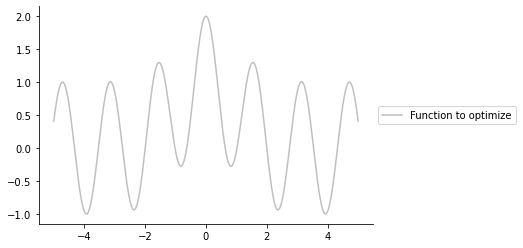

<IPython.core.display.Javascript object>

In [6]:
fix, ax = plot(x_init, y_init)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

To optimize this function, we define functions to fit a a surrogate model, predict using the model fit

In [7]:
def fit_gp(x, y):
    kernel = gpflow.kernels.RBF()
    gp = gpflow.models.GPR(
        (x, y), kernel, mean_function=gpflow.mean_functions.Constant()
    )
    return gp

<IPython.core.display.Javascript object>

In [8]:
def predict_gp(gp, x):
    y_hat, y_hat_var = gp.predict_f(x)
    return y_hat.numpy(), y_hat_var.numpy()

<IPython.core.display.Javascript object>

As acquisition function we use the upper confidence bound.

In [9]:
def acquisition_function(gp, x, conf):
    y_hat, y_hat_var = predict_gp(gp, x)
    ucb = y_hat + conf * np.sqrt(y_hat_var)
    return ucb

<IPython.core.display.Javascript object>

Finally, we define a function that proposes the next point to evaluate.

In [10]:
def acquire(x_d, y_d, x_init, conf=2.0):
    gp = fit_gp(x_d, y_d)
    y_hat, y_hat_var = predict_gp(gp, x_init)
    ucb = acquisition_function(gp, x_init, conf)
    x_next = x_init[np.argmax(ucb)]
    return x_next, ucb, y_hat, y_hat_var

<IPython.core.display.Javascript object>

We start with a random point on the interval defined above and query it against the function that we want to evaluate

In [11]:
np.random.seed(42)

x_n = st.uniform.rvs(-5, 5, size=(1))
y_n = f(x_n)

<IPython.core.display.Javascript object>

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [12]:
x_d = np.array([x_n])
y_d = np.array([y_n])
x_n, acqs, y_hat, y_hat_var = acquire(x_d, y_d, x_init)

<IPython.core.display.Javascript object>

We then plot the results after the first BO iteration:

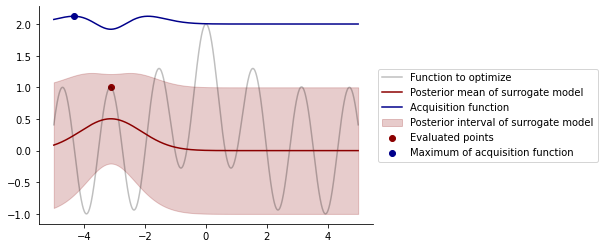

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_n, np.max(acqs), color="darkblue", label="Maximum of acquisition function"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Every iteration, we add the newly acquired point and add it to fit the surrogate model.

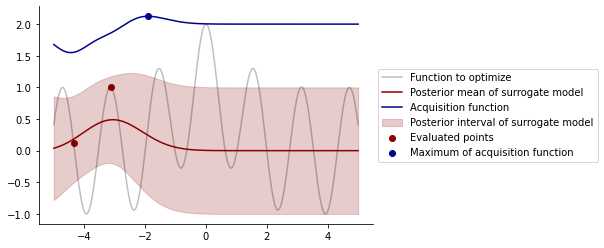

<IPython.core.display.Javascript object>

In [14]:
y_n = f(x_n)

x_d = np.vstack([x_d, x_n])
y_d = np.vstack([y_d, y_n])
x_n, acqs, y_hat, y_hat_var = acquire(x_d, y_d, x_init)

fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_n, np.max(acqs), color="darkblue", label="Maximum of acquisition function"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

And another time:

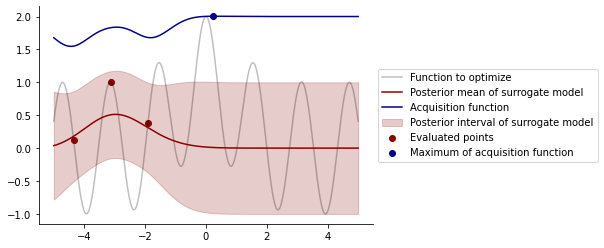

<IPython.core.display.Javascript object>

In [15]:
y_n = f(x_n)
x_d = np.vstack([x_d, x_n])
y_d = np.vstack([y_d, y_n])
x_n, acqs, y_hat, y_hat_var = acquire(x_d, y_d, x_init)

fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_n, np.max(acqs), color="darkblue", label="Maximum of acquisition function"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We repeat the procedure a couple of times, and would then just take the $x$ that maximizes the #f#.

In [16]:
for i in range(10):
    y_n = f(x_n)
    x_d = np.vstack([x_d, x_n])
    y_d = np.vstack([y_d, y_n])
    x_n, acqs, y_hat, y_hat_var = acquire(x_d, y_d, x_init)

<IPython.core.display.Javascript object>

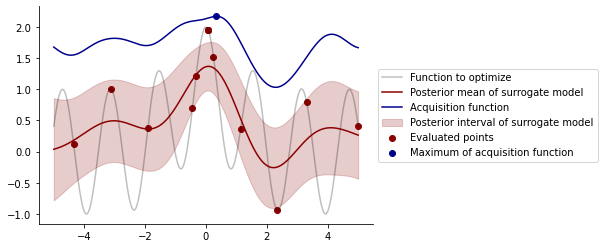

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_n, np.max(acqs), color="darkblue", label="Maximum of acquisition function"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Batch Bayesian optimization

In cases where we want to query multiple points at once, we need to come up with another strategy. One way to do that is, to propose a new point, then penalize the acquisition function around the region of the proposed point, and then propose another point by using the penalized acquisition function.

Below we demonstrate the proposed method by [Gonzales *et al.*](http://proceedings.mlr.press/v51/gonzalez16a.pdf).

First we define some required functions.

In [18]:
def m(gp, x_init):
    y_hat, _ = predict_gp(gp, x_init)
    return np.max(y_hat)

<IPython.core.display.Javascript object>

We approximate the gradient of the posterior predictive mean using finite differences.

In [19]:
def posterior_gradient(gp, x_init):
    h = 0.00000000001
    y_hat, _ = predict_gp(gp, x_init)
    y_h_hat, _ = predict_gp(gp, x_init + h)
    y_hat_grad = (y_h_hat - y_hat) / h

    return y_hat, y_hat_grad

<IPython.core.display.Javascript object>

In [20]:
def lipschitz(gp, x_init):
    _, y_hat_grad = posterior_gradient(gp, x_init)
    return np.max(y_hat_grad)

<IPython.core.display.Javascript object>

The function $\phi$ penalizes the acquisiation function around a point $\mathbf{x}_j$.

In [22]:
def phi(gp, x, x_j, L, M):
    y_hat, y_hat_var = predict_gp(gp, np.atleast_2d(x_j))
    dist = distance.cdist(np.atleast_2d(x), np.atleast_2d(x_j))

    z = (L * dist - M + y_hat) / (np.sqrt(2 * y_hat_var))
    z = 0.5 * sp.special.erfc(-z)
    return np.squeeze(z)

<IPython.core.display.Javascript object>

The penalized acquisition function first squashes the value of the original acqusition function and then penalizes this function around the previously proposed points where the width of the penalized region is goverened by $L$ and $M$.

In [23]:
def penalized_acquisition(gp, x, x_t, M, L, conf=2.0):
    def _g(x):
        idx = np.where(x <= 0)
        x[idx] = np.log(1 + np.exp(x[idx]))
        return x

    trans_ucb = _g(acquisition_function(gp, x, conf))
    penalty = np.prod(
        np.array([phi(gp, x, x_tj, L, M) for x_tj in x_t]), axis=0
    ).reshape(-1, 1)
    return trans_ucb * penalty

<IPython.core.display.Javascript object>

Let's simulate one iteration  $j$ one point at a time. We start again, by simulating an initial data set.

In [24]:
np.random.seed(42)

x_d = np.array([st.uniform.rvs(-5, 5, size=(1))])
y_d = np.array(f(x_d))

<IPython.core.display.Javascript object>

We update the surrogate model based on the existing data

In [25]:
gp = fit_gp(x_d, y_d)
y_hat, y_hat_var = predict_gp(gp, x_init)

<IPython.core.display.Javascript object>

Using the surrogate model, we estimate $\hat{L}$ and $\hat{M}$.

In [26]:
M, L = m(gp, x_init), lipschitz(gp, x_init)

<IPython.core.display.Javascript object>

We then propose the first point $x_{j1}$:

In [27]:
acqs = penalized_acquisition(gp, x_init, [], M, L)

<IPython.core.display.Javascript object>

The first point is the same as before (where we didn't use local penalization), since the penalizer is one, i.e., no region of the acquisition function is reduced.

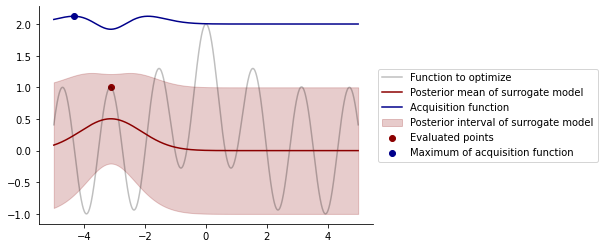

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_init[np.argmax(acqs)],
    np.max(acqs),
    color="darkblue",
    label="Maximum of acquisition function",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We add the proposed point $x_{j1}$ to the list of points to penalize around and select the next point:

In [34]:
x_t = [x_init[np.argmax(acqs)]]
acq_max_t = [np.max(acqs)]

acqs = penalized_acquisition(gp, x_init, x_t, M, L)

<IPython.core.display.Javascript object>

The penalization around the previously selected point can be nicely seen in the acquisition function.

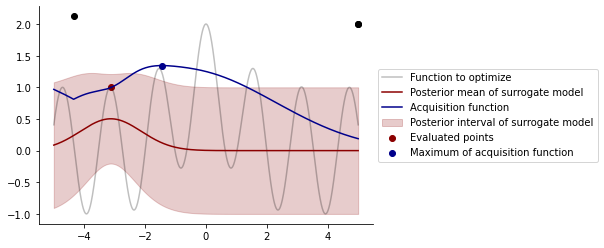

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
for x, acq_max in zip(x_t, acq_max_t):
    plt.scatter(x, acq_max, color="black")
plt.scatter(
    x_init[np.argmax(acqs)],
    np.max(acqs),
    color="darkblue",
    label="Maximum of acquisition function",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

More concretely, the acquisition function at the previously selected point is its minimum:

In [49]:
x_t

array([[-4.34934935],
       [ 5.        ],
       [ 5.        ]])

<IPython.core.display.Javascript object>

In [50]:
x_init[np.argmin(acqs)]

array([5.])

<IPython.core.display.Javascript object>

Let's propose another batch:

In [52]:
x_t = np.vstack([x_t, x_init[np.argmax(acqs)]])
acq_max_t = np.vstack([acq_max_t, np.max(acqs)])

acqs = penalized_acquisition(gp, x_init, x_t, M, L)

<IPython.core.display.Javascript object>

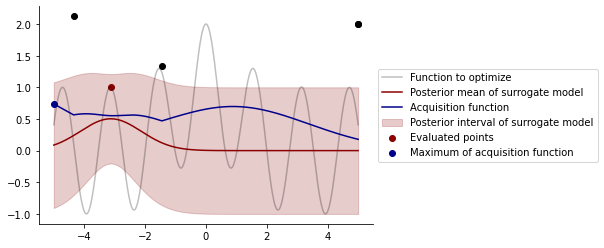

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
for x, acq_max in zip(x_t, acq_max_t):
    plt.scatter(x, acq_max, color="black")
plt.scatter(
    x_init[np.argmax(acqs)],
    np.max(acqs),
    color="darkblue",
    label="Maximum of acquisition function",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Batch Bayesian optimization in practice

Let's try to optimize the above function with it as above. We first update the function we use to acquire a new point to return a batch of points, with the logic from above

In [55]:
def acquire(x_d, y_d, x_init, nb=3, conf=1.96):
    gp = fit_gp(x_d, y_d)
    y_hat, y_hat_var = predict_gp(gp, x_init)

    M, L = m(gp, x_init), lipschitz(gp, x_init)
    x_t = []
    acq_max_t = []
    acqs_t = []
    for i in range(nb):
        acqs = penalized_acquisition(gp, x_init, x_t, M, L, conf)
        x_t.append(x_init[np.argmax(acqs)])
        acq_max_t.append(np.max(acqs))
        acqs_t.append(acqs)

    return x_t, acq_max_t, acqs_t, y_hat, y_hat_var

<IPython.core.display.Javascript object>

We then take a batch of points.

In [56]:
x_t, acq_max_t, acqs_t, y_hat, y_hat_var = acquire(x_d, y_d, x_init, nb=3)

<IPython.core.display.Javascript object>

Every batch consists of 3 points. Below we show how for every new point the acquisition function gets penalized around the points that have been proposed before. In iteration 1, the acquisition function is the same as the acquisition function without penalization. In the succeeding iterations, the acquisition function is getting penalized around the points before

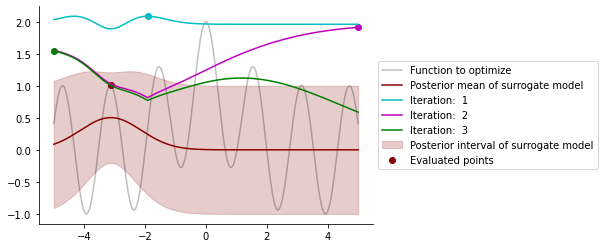

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])

for i, (x_tj, acq_tj, acqs_tj) in enumerate(zip(x_t, acq_max_t, acqs_t)):
    plt.scatter(x_tj, acq_tj, color=colors[i])
    plt.plot(x_init, acqs_tj, color=colors[i], label=f"Iteration:  {str(i + 1)}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We then add the points to the data set, query them against function $f$ and then get then next patch of points.

In [60]:
x_d = np.vstack([x_d, x_t])
y_d = np.vstack([y_d, f(np.array(x_t))])

x_t, acq_max_t, acqs_t, y_hat, y_hat_var = acquire(x_d, y_d, x_init, nb=3)

<IPython.core.display.Javascript object>

As before, we plot the the next batch of points.

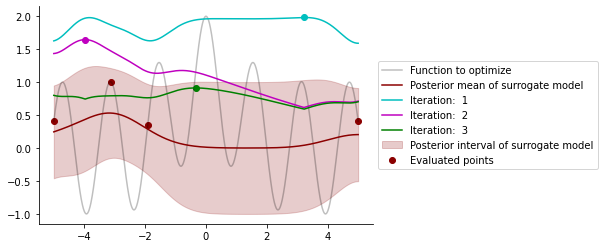

<IPython.core.display.Javascript object>

In [62]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])

for i, (x_tj, acq_tj, acqs_tj) in enumerate(zip(x_t, acq_max_t, acqs_t)):
    plt.scatter(x_tj, acq_tj, color=colors[i])
    plt.plot(x_init, acqs_tj, color=colors[i], label=f"Iteration:  {str(i + 1)}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Let's repeat this for some iterations and see if we propose reasonable points.

In [63]:
for i in range(5):
    x_d = np.vstack([x_d, x_t])
    y_d = np.vstack([y_d, f(np.array(x_t))])
    x_t, acq_max_t, acqs_t, y_hat, y_hat_var = acquire(x_d, y_d, x_init, nb=3)

<IPython.core.display.Javascript object>

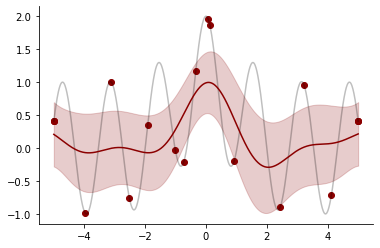

<IPython.core.display.Javascript object>

In [64]:
fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.show()